In [2]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
# print(plt.style.available)
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

In [3]:
# 加载数据
data_df = pd.read_csv('../data/raw/stock_dataset_2.csv', parse_dates=True, index_col=1)
# 确保日期列为datetime类型
# data['date'] = pd.to_datetime(data['date'])

data_df.info()



# 数据集划分
# train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6109 entries, 1990-12-20 to 2015-12-10
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index_code  6109 non-null   object 
 1   open        6109 non-null   float64
 2   close       6109 non-null   float64
 3   low         6109 non-null   float64
 4   high        6109 non-null   float64
 5   volume      6109 non-null   float64
 6   money       6109 non-null   float64
 7   change      6109 non-null   float64
 8   label       6109 non-null   float64
dtypes: float64(8), object(1)
memory usage: 477.3+ KB


In [4]:
attribution = ['open', 'close', 'low', 'high', 'volume', 'money', 'change']
data_df = data_df[attribution]
data_df.info()
data_df.values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6109 entries, 1990-12-20 to 2015-12-10
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6109 non-null   float64
 1   close   6109 non-null   float64
 2   low     6109 non-null   float64
 3   high    6109 non-null   float64
 4   volume  6109 non-null   float64
 5   money   6109 non-null   float64
 6   change  6109 non-null   float64
dtypes: float64(7)
memory usage: 381.8 KB


array([[ 1.04300000e+02,  1.04390000e+02,  9.99800000e+01, ...,
         1.97000000e+05,  8.50000000e+04,  4.41088220e-02],
       [ 1.09070000e+02,  1.09130000e+02,  1.03730000e+02, ...,
         2.80000000e+04,  1.61000000e+04,  4.54066480e-02],
       [ 1.13570000e+02,  1.14550000e+02,  1.09130000e+02, ...,
         3.20000000e+04,  3.11000000e+04,  4.96655370e-02],
       ...,
       [ 3.51865000e+03,  3.47007000e+03,  3.46679000e+03, ...,
         2.24367310e+08,  2.98000000e+11, -1.89033990e-02],
       [ 3.46258000e+03,  3.47244000e+03,  3.45488000e+03, ...,
         1.95698845e+08,  2.68000000e+11,  6.82983000e-04],
       [ 3.46981000e+03,  3.45550000e+03,  3.44627000e+03, ...,
         2.00427517e+08,  2.79000000e+11, -4.87841400e-03]])

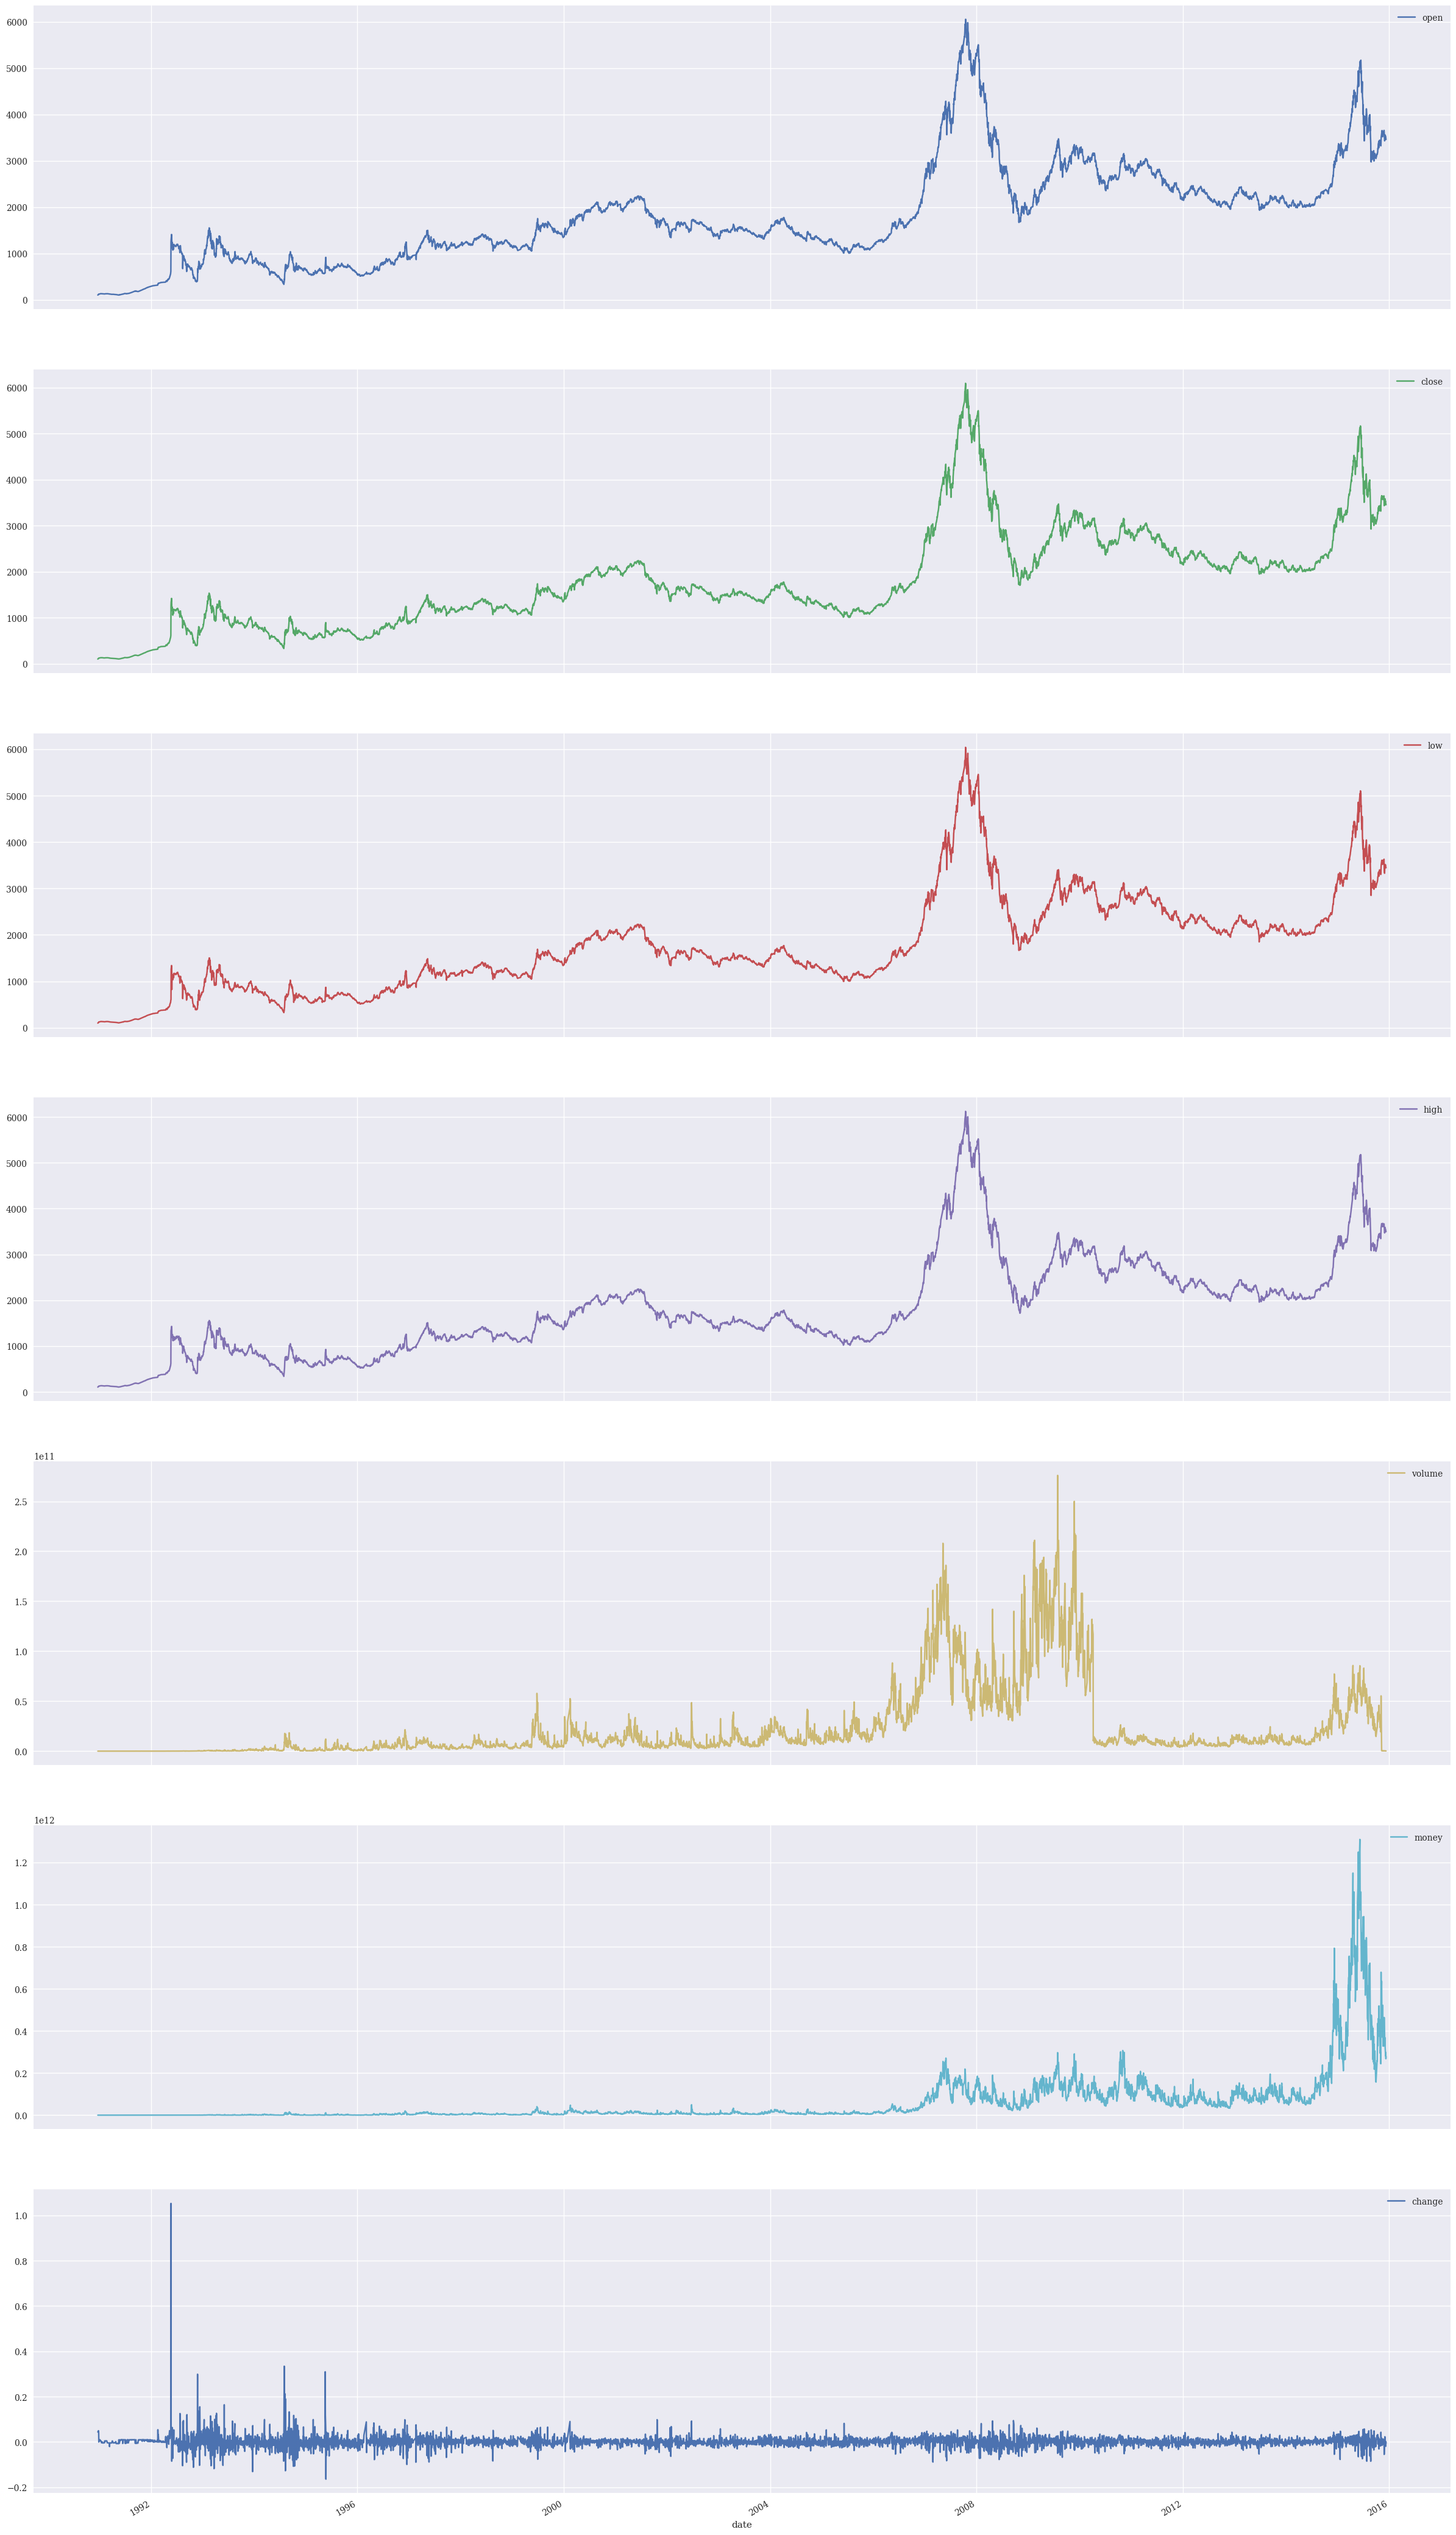

In [5]:
data_df.plot(subplots=True, figsize=(30, 60))
# 绘制每个子图，并设置字体大小
# 创建子图
# fig, axes = plt.subplots(nrows=len(data.columns), ncols=1, figsize=(80, 240))
# for i, column in enumerate(data.columns):
#     data[column].plot(ax=axes[i])
#     axes[i].set_title(column, fontsize=30)   # 设置标题字体大小
#     axes[i].set_xlabel('X-axis label', fontsize=25)  # 设置 x 轴标签字体大小
#     axes[i].set_ylabel('Y-axis label', fontsize=25)  # 设置 y 轴标签字体大小
plt.plot()
plt.show()

In [6]:
# 归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
data_df.values
data = scaler.fit_transform(data_df) # 此处归一化时机有问题，训练集和测试集应该分开归一化

print('data:', data)
data.shape #narray
# data.values


data: [[-1.         -1.         -1.         ... -0.99999868 -0.99999988
  -0.6579966 ]
 [-0.99839748 -0.99841675 -0.99873753 ... -0.99999991 -0.99999999
  -0.65586312]
 [-0.99688567 -0.99660636 -0.99691957 ... -0.99999988 -0.99999996
  -0.64886198]
 ...
 [ 0.14707725  0.12420357  0.13346676 ... -0.99837426 -0.54503818
  -0.76158163]
 [ 0.1282401   0.1249952   0.12945715 ... -0.998582   -0.5908397
  -0.72938382]
 [ 0.13066908  0.1193369   0.12655852 ... -0.99854774 -0.57404581
  -0.73852613]]


(6109, 7)

In [11]:
# 创建训练、测试数据集
def load_data(stock_df, look_back):
    data_raw = stock_df.values
    data = []
    
    # 创建长度为look_back的所有可能序列
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index+look_back])
        
    # data.shape #list没有shape属性
    
    data = np.array(data)
    print('data.shape', data.shape)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    print('set_size',train_set_size,test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_test = data[train_set_size:,:-1, :]
    y_test = data[train_set_size:, -1, :]
    
    
    return [x_train, y_train, x_test, y_test]
    
look_back = 60
x_train, y_train, x_test, y_test = load_data(data_df, look_back)
print('x_train.shape', x_train.shape)
print('y_train.shape', y_train.shape)
print('x_test.shape', x_test.shape)
print('y_test.shape', y_test.shape)


data.shape (6049, 60, 7)
set_size 4839 1210
x_train.shape (4839, 59, 7)
y_train.shape (4839, 7)
x_test.shape (1210, 59, 7)
y_test.shape (1210, 7)


In [12]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [15]:
x_train.size(),y_train.size(),x_test.size(),y_test.size()

(torch.Size([4839, 59, 7]),
 torch.Size([4839, 7]),
 torch.Size([1210, 59, 7]),
 torch.Size([1210, 7]))